In [10]:
#importing libraries
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import sys

# 1Q. Implement a function Count_hole( ) that takes a black and white image (imghole.jpg) as input and returns number of holes in that image. Use morphological and logical operations in the Count_hole() function implementation.

In [11]:
import cv2
import numpy as np

def count_holes(image):
    # Preprocessing steps
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    cv2.imshow('opened', opened)
    cv2.waitKey(0)
    _, thresholded = cv2.threshold(opened, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    cv2.imshow('thresholded', thresholded)
    cv2.waitKey(0)
    # Invert the thresholded image
    inverted = cv2.bitwise_not(thresholded)
    cv2.imshow('inverted', inverted)
    cv2.waitKey(0)
    # Perform connected component labeling
    _, labels = cv2.connectedComponents(inverted)

    # Subtract 1 from the total number of labels to account for the background label
    hole_count = labels.max() - 1

    return hole_count




image_path = "imghole.jpg"
img=cv2.imread("imghole.jpg",0)
num_holes = count_holes(img)
print('Number of holes:', num_holes)

Number of holes: 10


# 2Q. Implement a program that uses thresholding and morphological operations to segment the organ of interest in the given CT image, abdomen.jpg. Organs of interest are shown in the below image

Text(0.5, 1.0, 'Segmented image')

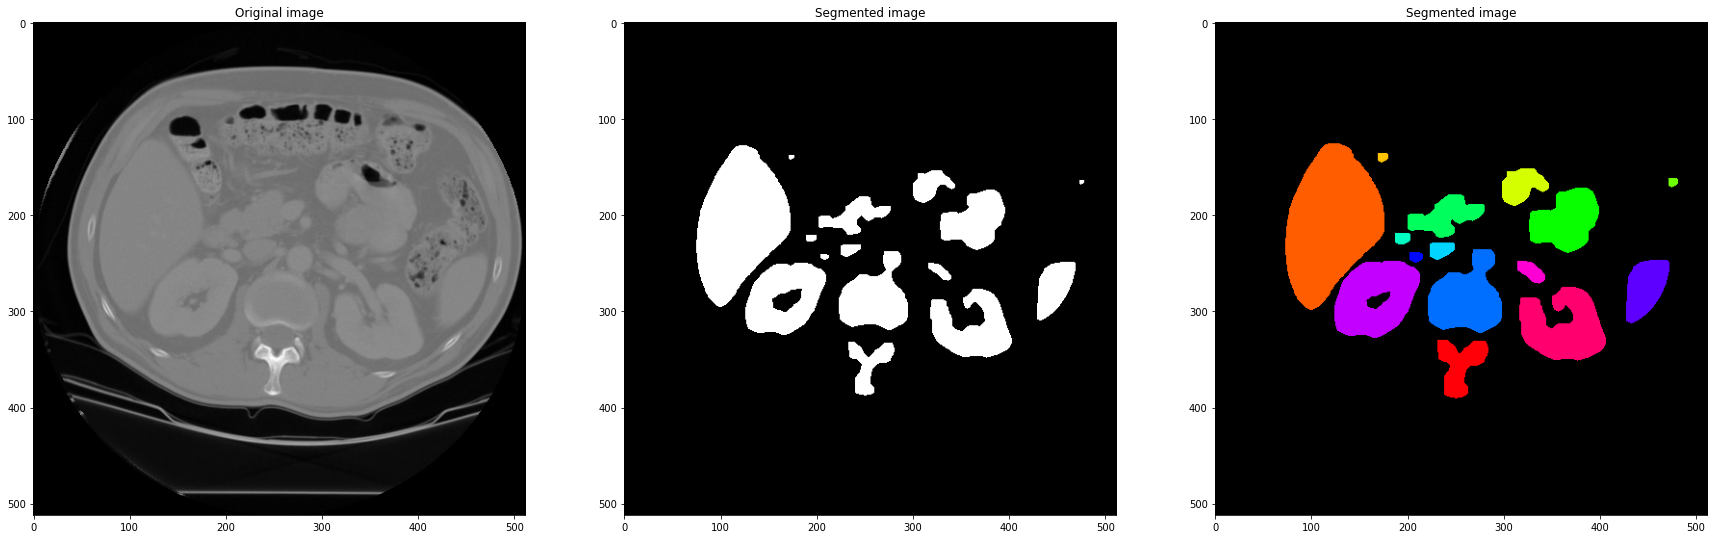

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read input image
img = cv2.imread("abdomen.jpg")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray = cv2.GaussianBlur(gray, (5, 5), 0)

ret, thresh = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY)
# Apply morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Find contours and draw them on the image
contours, hierarchy = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(opening, contours, -1, (0, 255, 0), 3)
ans=cv2.dilate(opening, kernel, iterations=1) 
num_labels, labels = cv2.connectedComponents(ans)
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
label_hue = np.uint8(179*labels/np.max(labels))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
labeled_img[label_hue==0] = 0

fig=plt.figure(figsize=(30,30))
fig.add_subplot(2,3,1)
plt.gray()
plt.imshow(img)
plt.title("Original image")
fig.add_subplot(2,3,2)
plt.gray()
plt.imshow(opening)
plt.title("Segmented image")
fig.add_subplot(2,3,3)
plt.gray()
plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB))
plt.title("Segmented Color image")

# 3Q. Implement your own program to detect number of circles in the image disks.png using the circle Hough transforms method and compare the obtained output with built-in function output.

Number of circles found without built-in function:  14
Number of circles found with built-in function:  14


Text(0.5, 1.0, 'Image with Built-In function')

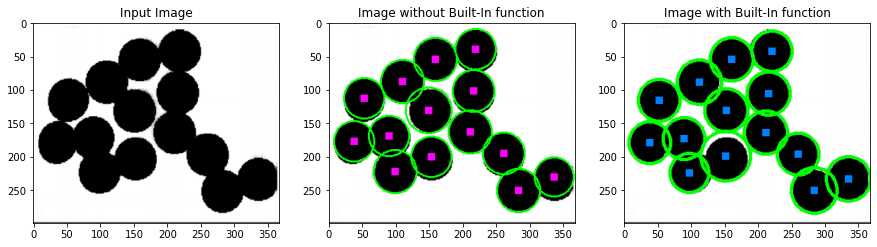

In [50]:
def Hough_transform(image_path):

    # Load the image and convert it to grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Define the range of radii of circles to detect
    min_radius = 20
    max_radius = 50
    num_radii = max_radius - min_radius + 1
    radii = np.arange(min_radius, max_radius+1)

    # Initialize the accumulator array with zeros
    accumulator = np.zeros((gray.shape[0], gray.shape[1], num_radii))

    # Threshold the image to get the edge map
    edges = cv2.Canny(gray, 50, 150)

    # For each edge pixel, calculate the (x,y) coordinates of the center of the circle
    # that would pass through that pixel for each radius in the range
    for y in range(edges.shape[0]):
        for x in range(edges.shape[1]):
            if edges[y,x] > 0:
                for i, radius in enumerate(radii):
                    for angle in range(0, 360, 10):
                        a = int(x - radius*np.cos(angle*np.pi/180))
                        b = int(y - radius*np.sin(angle*np.pi/180))
                        if a >= 0 and a < edges.shape[1] and b >= 0 and b < edges.shape[0]:
                            accumulator[b,a,i] += 1

    # Find the local maxima in the accumulator array
    circles = []
    threshold = 0.5*np.max(accumulator)
    for y in range(accumulator.shape[0]):
        for x in range(accumulator.shape[1]):
            for i in range(accumulator.shape[2]):
                if accumulator[y,x,i] > threshold:
                    # Check if there is no overlapping circle within a certain distance
                    is_maxima = True
                    for circle in circles:
                        if np.sqrt((circle[0]-x)**2 + (circle[1]-y)**2) < circle[2]:
                            is_maxima = False
                            break
                    if is_maxima:
                        circles.append((x,y,radii[i]))

    # Display the original image with the detected circles overlayed
    output = img.copy()
    for circle in circles:
        cv2.circle(output, (circle[0], circle[1]), circle[2], (0,255,0), 2)
        cv2.rectangle(output, (circle[0] - 5, circle[1] - 5), (circle[0] + 5, circle[1] + 5), (255, 0, 255), -1)
    return (output,len(circles))



img = cv2.imread("disks.png")
output1, num_circles1 = Hough_transform("disks.png")
output2 = img.copy()
# Print the number of circles found
print(f"Number of circles found without built-in function: ", num_circles1)



# built-in function method


# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Reduce the noise to avoid false circle detection
blur = cv2.GaussianBlur(gray,(5,5),7)

rows = blur.shape[0]
circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1.5, rows / 8, param1=30, param2=30, minRadius=1, maxRadius=70)
                                                                

# detect circles in the image
# ensure at least some circles were found
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circles:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.circle(output2, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(output2, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

num_circles2 = len(circles)
print(f"Number of circles found with built-in function: ", num_circles2)
plt.figure(figsize=(15, 15))
plt.subplot(2,3,1)
plt.imshow(img)
plt.title("Input Image")

plt.subplot(2,3,2)
plt.imshow(output1)
plt.title("Image without Built-In function")

plt.subplot(2,3,3)
plt.imshow(output2)
plt.title("Image with Built-In function")

# 4Q. Implement a program to detect moving vehicles by using median differencing background subtraction technique and mention your observations on the result. Use traffic.3gp video clip to test your code.

In [12]:
vid = cv2.VideoCapture('traffic.3gp')
# value of n : last n frames for median
n = 5
lastNFrames = []
flag=True
while flag:
    # reading each frame of video
    ret, frame = vid.read()
    try:
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
        # maintaining buffer of last N frames in a list
        lastNFrames.append(frame)
        if len(lastNFrames) == n:
            lastNFrames.pop(0)
        
        # Computing median of last N frames
        medianImgs = np.array(lastNFrames)
        medianImg = np.median(medianImgs,axis=0)
        medianImg = medianImg.astype(np.uint8)
        
        # Taking background by finding absolute difference of original frame and median image
        tempImage = cv2.absdiff(frame,medianImg)
        light = np.array([255],np.uint8)
        dark = np.array([0],np.uint8)
        
        # extracting foreground
        foreground = np.where(tempImage>10,light,dark)
        # using gaussian kerenl to perform opening operation to remove smaller unrequired details
        kernel  = cv2.getGaussianKernel(5,2)
        foregroundErode = cv2.erode(foreground,kernel,iterations =1)
        foregroundDilate = cv2.dilate(foregroundErode,kernel,iterations =1)
        # using above image as mask to make final foreground of moving objects
        foregroundFinal =  cv2.bitwise_and(frame,frame,mask = foregroundDilate)
        cv2.imshow('Moving Objects',foregroundFinal)
        k = cv2.waitKey(5) & 0xFF
    except:
        vid.release()
        cv2.destroyAllWindows()
        flag=False



# 5Q. Write a program to perform robust image matching using RANSAC algorithm and Harris Corner features. Use FM_img1.jpg and FM_img2.jpg to test the program.

([], [])

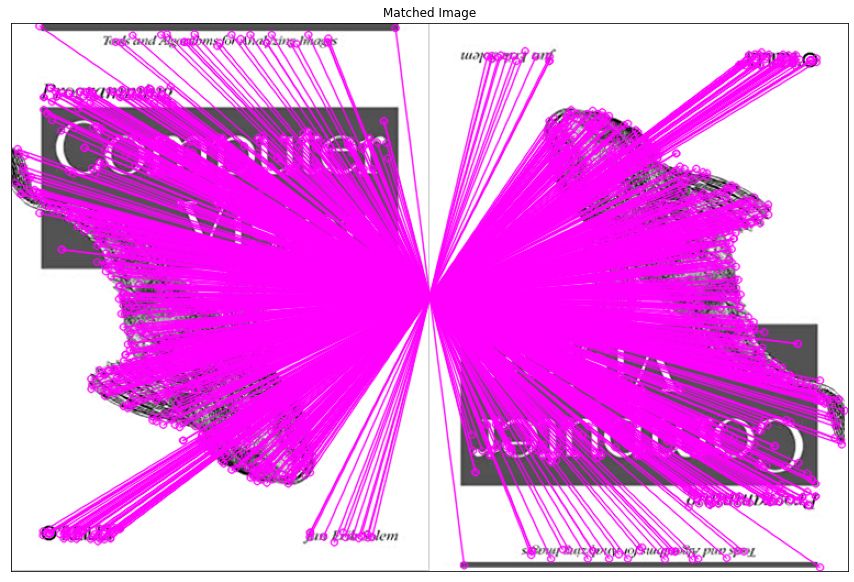

In [6]:
# doing feature matching using SIFT(for getting the features) and RANSAC(for matching those features)

MIN_MATCH_COUNT = 10

# refernce image
img1 = cv2.imread('FM_img1.jpg',0) 

# image to match
img2 = cv2.imread('FM_img2.jpg',0)          

# creating a SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors using SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

# check whether enough feature points were detected to match
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # implementation of RANSAC for feature matching   
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print("Not enough matches were found ->",len(good)," But needed ->",MIN_MATCH_COUNT)
    matchesMask = None

# draw matches in pink color (only inliners)
draw_params = dict(matchColor = (255,0,255), singlePointColor = None,matchesMask = matchesMask, flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

# displaying the image
plt.figure(figsize=(15, 15))
img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)
plt.imshow(img3)
plt.title("Matched Image")
plt.xticks([])
plt.yticks([])


# 6Q. Write a program to implement Otsu’s algorithm for global threshold-based image segmentation. Use Boat_Otsu.png image to test your code

Otsu's algorithm implementation thresholding result:  132.978515625


Text(0.5, 1.0, 'Segmented image')

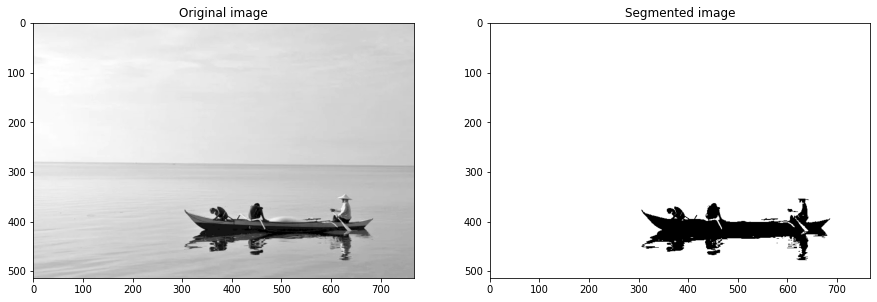

In [13]:
#reading image
image = cv2.imread('Boat_Otsu.png', 0)

original_image = image.copy()

#generating histogram for the image
hist, bin_edges = np.histogram(image, 256)

#normalization of the histogram
hist=np.divide(hist,hist.max())

#each bin's middle value is considered as the pixel value
pixel_values = (bin_edges[:-1] + bin_edges[1:]) / 2

# weights
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

# mean values
mean1 = np.cumsum(hist * pixel_values) / weight1
mean2 = (np.cumsum((hist * pixel_values)[::-1]) / weight2[::-1])[::-1]

# calculating the variance
between_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

# Maximize the between_class_variance function val
index_of_max_val = np.argmax(between_class_variance)

threshold = pixel_values[:-1][index_of_max_val]
print("Otsu's algorithm implementation thresholding result: ", threshold)

image[image > threshold]=255
image[image <threshold]=0

fig=plt.figure(figsize=(15,15))
fig.add_subplot(2,2,1)
plt.gray()
plt.imshow(original_image)
plt.title("Original image")
fig.add_subplot(2,2,2)
plt.gray()
plt.imshow(image)
plt.title("Segmented image")
